In [1]:

%load_ext autoreload
%autoreload 2
import networkx as nx
import matplotlib.pyplot as plt
import random
#from pcc_implementacao import *
import pandas as pd
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
import numpy as np

from model import *
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

# Particle competition for complex network community detection
### Summary of the Process  
1. Initialization: Start with several particles placed randomly in the network, each with low potential.  
2. Iteration: In each step, particles choose a neighboring node to visit based in a mix of random and deterministic rules.  
3. Update Ownership: Depending on the visit outcome, update the ownership and potential of both the particle and the node.  
4. Convergence: Repeat the process until each community is owned by a single particle, indicating successful community detection.  


# Inicialização

2. Criação de uma rede aleatória clusterizada

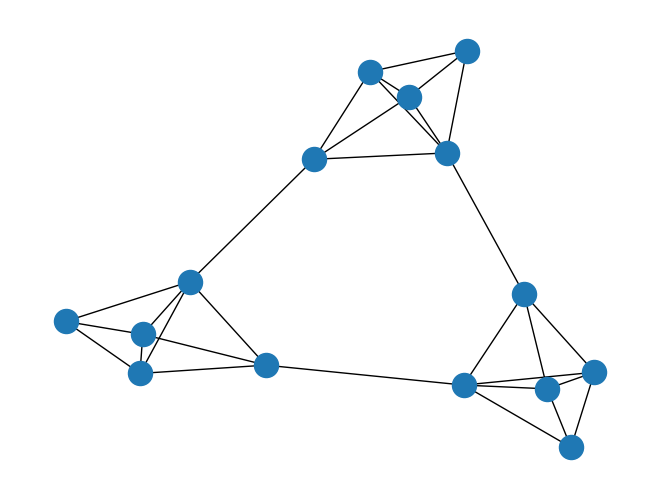

In [2]:
G_test = nx.connected_caveman_graph(3, 5)
nx.draw(G_test)

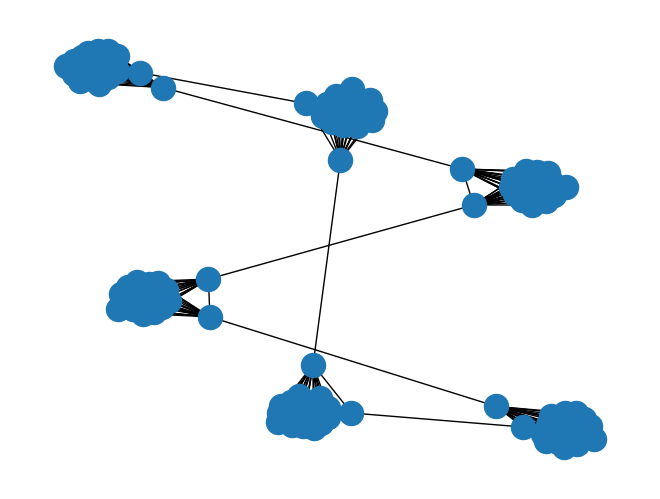

In [3]:
G_test = nx.connected_caveman_graph(6, 20)
nx.draw(G_test)

# Dataset

In [4]:
df_sar = pd.read_csv('data/sar_dataset.csv')
df_sar

,feature_1,feature_2,true_label,observed_label
0,1.496714,0.861736,positive,0
1,1.647689,2.523030,positive,0
2,0.765847,0.765863,positive,1
3,2.579213,1.767435,positive,0
4,0.530526,1.542560,positive,1
5,0.536582,0.534270,positive,0
6,1.241962,-0.913280,positive,1
7,-0.724918,0.437712,positive,0
8,-0.012831,1.314247,positive,0
9,0.091976,-0.412304,positive,0


In [5]:
px.scatter(df_sar, x = 'feature_1', y = 'feature_2', color = 'true_label')

# Graph Creation

In [6]:
# Choose the number of neighbors (k)
k = 3

Graph created with k=3
Number of nodes: 40
Number of edges: 81


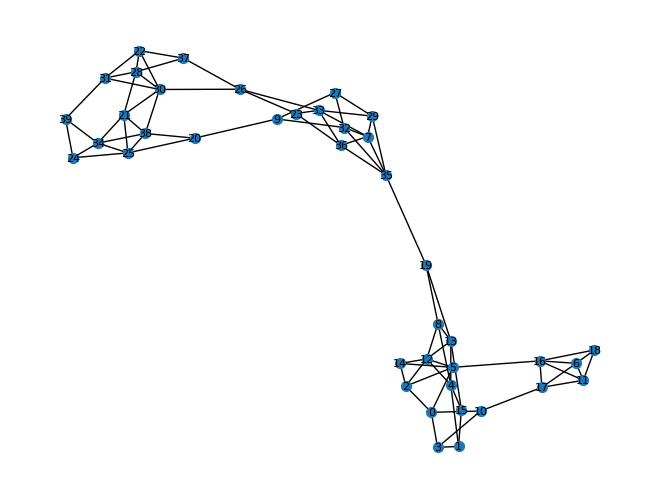

In [7]:
# --- 1. Define Nodes ---
# Nodes will correspond to the index of the dataframe rows
nodes = df_sar.index

# --- 2. Calculate Neighbors ---
# Select the features to calculate distance
features = df_sar[['feature_1', 'feature_2']].values


# We ask for k+1 neighbors because the point itself is always the closest (distance 0)
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(features)
distances, indices = nbrs.kneighbors(features)

# --- 3. Define Edges ---
# Create an edge list based on k-NN
# indices[i, 0] is always node i itself, so we start from indices[i, 1]
edge_list = []
for i in range(len(features)):
    for j_idx in range(1, k + 1): # Iterate through the k nearest neighbors (excluding self)
        neighbor_index = indices[i, j_idx]
        # Add edge (i, neighbor_index) - ensure order doesn't matter for undirected graph
        # We can add edges in both directions initially and NetworkX handles duplicates
        edge_list.append(tuple(sorted((i, neighbor_index))))


# Remove duplicate edges by converting to a set
unique_edges = set(edge_list)

# --- 4. Build Graph ---
# Create an empty graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(nodes)

# Add edges
G.add_edges_from(unique_edges)

# Optional: Add features/labels as node attributes
# Convert labels to string type if they aren't already, for compatibility
attributes = df_sar.to_dict('index') # Get attributes for each node (row index)
nx.set_node_attributes(G, attributes)
print(f"Graph created with k={k}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

nx.draw(G, with_labels=True, node_size=50, font_size=8)
plt.savefig("graph_dataset.png", dpi=600)

In [8]:
G.nodes(data=True)[0]

{'feature_1': 1.496714153011233,
 'feature_2': 0.8617356988288154,
 'true_label': 'positive',
 'observed_label': 0}

# Execução

All conditions met. Stopping simulation.


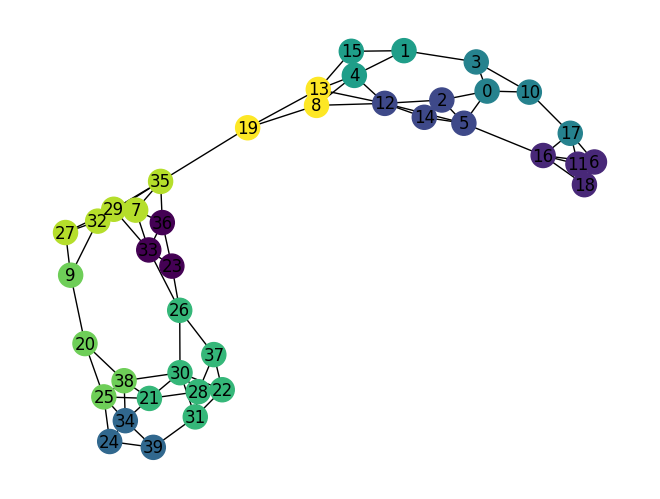

In [9]:
p_det = 0.4
M = 10 # number of particles
delta_p = 0.1
delta_v = 0.1


PCM = ParticleCompetitionModel(G, M,  p_det, delta_p, delta_v)
g_sim = PCM.run_simulation(2000)
PCM.visualize_communities(g_sim)

In [10]:
PCM.graph_without_owners()

False

In [11]:
PCM.check_average_node_potential()[1]

np.False_

In [12]:
PCM.check_positive_cluster_existence()

True

MCLS

In [15]:
mcls = MCLS(g_sim)
mcls.assign_cluster_label()
mcls.calculate_dissimilarity()
mcls.rank_nodes_dissimilarity(20)

[(39, 12),
 (21, 11),
 (22, 11),
 (24, 11),
 (28, 11),
 (31, 11),
 (34, 11),
 (25, 10),
 (30, 10),
 (37, 10),
 (38, 10),
 (20, 9),
 (26, 9),
 (9, 8),
 (23, 8),
 (27, 8),
 (33, 8),
 (7, 7),
 (29, 7),
 (32, 7)]

# Planetoid

In [13]:
def load_cora_for_pcm(positive_class_label: int = 3):
    """
    Loads the Cora dataset, converts it to a NetworkX graph, and sets it up
    for PU learning by assigning one class as Positive (1) and the rest
    as Unlabeled (0).

    Args:
        positive_class_label (int): The original label from Cora to be treated as the Positive class.

    Returns:
        nx.Graph: A NetworkX graph ready for the ParticleCompetitionModel.
    """
    # 1. Load the dataset
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]
    print(f"Loaded Cora dataset: {data}")

    # 2. Convert the PyG Data object to a NetworkX graph
    # Your model uses an undirected graph, so to_undirected=True is important.
    G = to_networkx(data, to_undirected=True)
    print(f"Converted to NetworkX. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # 3. Set up node attributes for PU Learning
    for i in range(data.num_nodes):
        node_label = data.y[i].item() # The original class label (0-6)

        # 'true_label' is for evaluation later. 1 if it's the positive class, 0 otherwise.
        G.nodes[i]['true_label'] = 1 if node_label == positive_class_label else 0
        
        # 'observed_label' is what the algorithm sees.
        # Mark the chosen positive class as 1 (P) and all others as 0 (U).
        G.nodes[i]['observed_label'] = 1 if node_label == positive_class_label else 0

    print(f"Set up PU labels with class {positive_class_label} as Positive.")
    
    # We don't need to add 'feature_1' or 'feature_2' as your PCM algorithm
    # doesn't use them, but this shows where the original features are.
    # The 'data.x' tensor holds these features if you need them later.
    # nx.set_node_attributes(G, data.x.numpy(), 'features')

    return G


In [19]:
G_cora= load_cora_for_pcm(3)

Loaded Cora dataset: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Converted to NetworkX. Nodes: 2708, Edges: 5278
Set up PU labels with class 3 as Positive.


In [ ]:
p_det = 0.6
M = 7
delta_p = 0.7
delta_v = 0.2
max_sim_iterations = 2000 


PCM = ParticleCompetitionModel(G_cora, M, p_det, delta_p, delta_v, cluster_strategy='percentage', positive_cluster_threshold=0.1)
g_sim = PCM.run_simulation()

In [ ]:
PCM.visualize_communities()

In [18]:
G.nodes()[0]

{'true_label': 1, 'observed_label': 1}

In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [3]:
G = to_networkx(data, to_undirected=True, node_attrs=["x", "y"])

In [12]:
data.y[30].item()

3

In [6]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [16]:
rank = mcls.rank_nodes_dissimilarity(20)

In [22]:
[g_sim.nodes[n]['true_label'] for n, _ in rank]

['negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative']

In [21]:
g_sim.nodes[0]

{'feature_1': 1.496714153011233,
 'feature_2': 0.8617356988288154,
 'true_label': 'positive',
 'observed_label': 0,
 'data': <core.Node at 0x759e00232ce0>,
 'cluster_positive': 0,
 'dissimilarity': 3}